# **Задание**

Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.




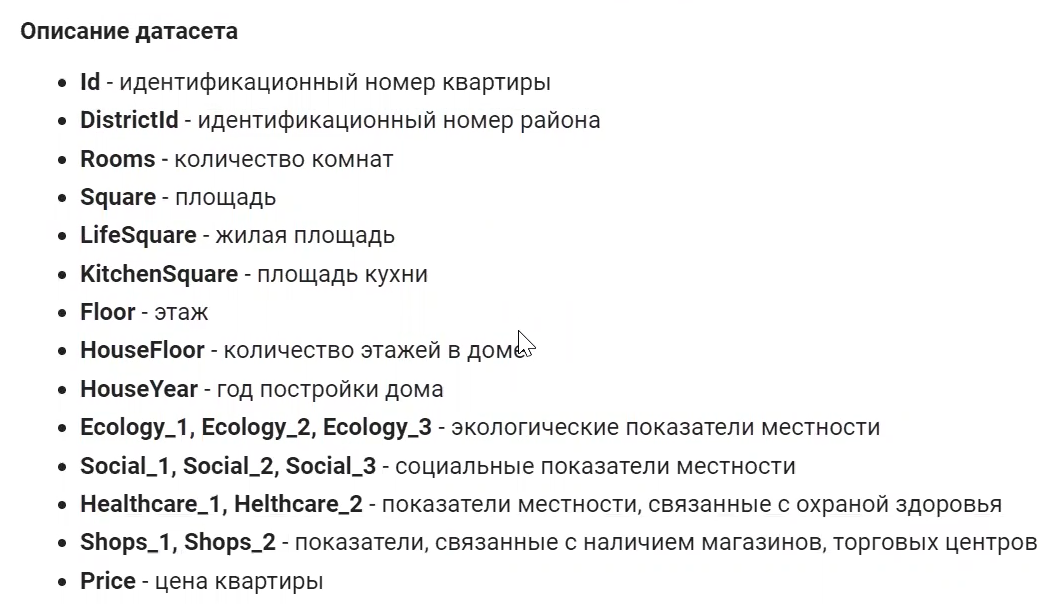

# **Импорт библиотек**

In [1]:
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# **Импорт исходных данных**

In [2]:
test = pd.read_csv('/content/sample_data/test.csv')
train = pd.read_csv('/content/sample_data/train.csv')

# **Анализ и подготовка обучающих данных**

In [3]:
train.shape

(10000, 20)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Как видно, признаки LifeSquare, Healthcare_1 содержат пустые значения.

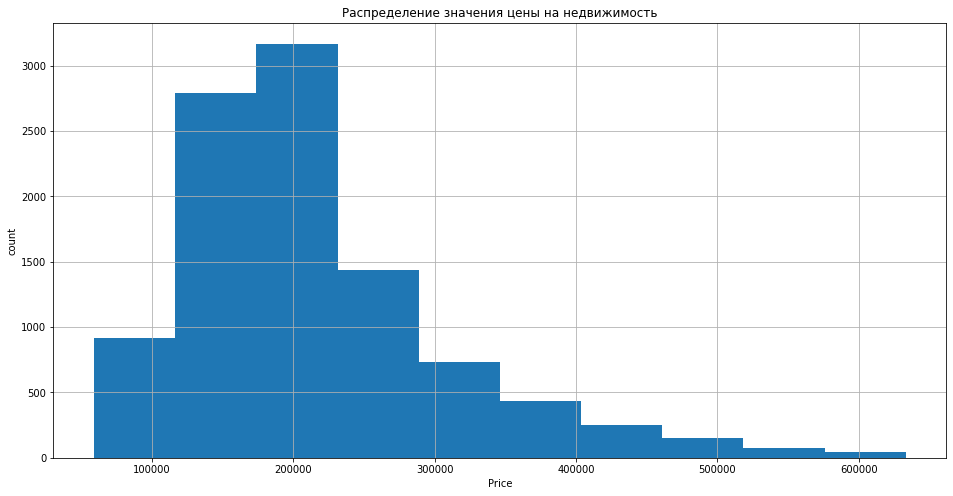

In [6]:
# Гистограмма целевой переменной из обучающего датасета

plt.figure(figsize = (16, 8))

train['Price'].hist()
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Распределение значения цены на недвижимость')
plt.show()

In [7]:
train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Налицо следующие аномалии:

*  Объекты с нулевым количеством комнат;
*  Минальное зачение общей площади в 1,13 м^2;
*  Значение 7480 м^2 жилой площади и кухни 2014 м^2 при 641 м^2 общей площади;
*  Четырехзначные, пятизначные, семизначаные годы постройки;
*  25% объектов с площадью кухонь менее 1 м^2
*  Нулевая этажность зданий;

In [8]:
# Рассмотрим подробнее объекты с нулевым количеством комнат

train[train['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
2269,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
3911,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007


In [9]:
# Явная аномалия - объект без комнат с площадью 2.3 м^2. На первом этаже. Удалим его.

train = train.drop(labels=4853, axis=0, inplace=False)

In [10]:
# Просмотр распределения объектов по количеству комнат.

train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        7
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [11]:
# Заменим аномалии по 10 и 19 комнат на моду (2 комнаты).

train.loc[train['Rooms'].isin([10,19]),'Rooms']=train['Rooms'].mode()

In [12]:
# Замена пустых значений в LifeSquare и Healthcare_1 на медианные

train.loc[train['LifeSquare'].isnull(), 'LifeSquare'] = train['LifeSquare'].median()

train.loc[train['Healthcare_1'].isnull(), 'Healthcare_1'] = train['Healthcare_1'].median()

#train = train[(train['Square'] < train['Square'].quantile(.975)) | 
              # (train['Square'] > train['Square'].quantile(.05))]

#train = train[train['LifeSquare'].isnull() | 
              #(train['LifeSquare'] < train['LifeSquare'].quantile(.975)) |
             # (train['LifeSquare'] > train['LifeSquare'].quantile(.05))]

#train = train[(train['KitchenSquare'] < train['KitchenSquare'].quantile(.975)) | 
             # (train['KitchenSquare'] > train['KitchenSquare'].quantile(.05))]


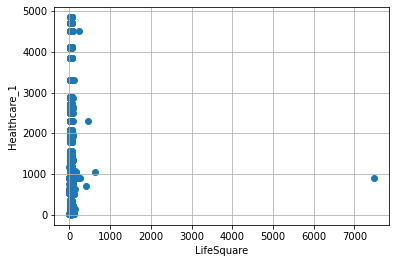

In [13]:
# Рассмотрим диграмму рассения по признакам LifeSquare и Healthcare_1 после замены пустых значений на медианные

plt.scatter(train['LifeSquare'], train['Healthcare_1'])
plt.xlabel('LifeSquare')
plt.ylabel('Healthcare_1')
plt.grid()
plt.show()  

Как видно, имеется аномалия при LifeSquare > 7000

In [14]:
train[train.LifeSquare > 7000]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4328,16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,2016,0.017647,B,B,2,469,0,900.0,0,0,B,217357.492366


In [15]:
# Удалим ее

train = train.drop(labels=4328, axis=0, inplace=False)

In [16]:
# Зададим минимальную площадь кухни не менее 3 м^2

train.loc[train['KitchenSquare'] <3, 'KitchenSquare'] = 3

In [17]:
# Заменим нулевую этажность домов на медианную

train.loc[train['HouseFloor'] == 0, 'HouseFloor'] = train['HouseFloor'].median()

In [18]:
# Заменим аномалию объектов недвижимости, которые расположены выше этажности здания

abnormal_floor = train.loc[train['Floor'] > train['Floor']].index
train.loc[abnormal_floor, 'Floor'] = train.loc[abnormal_floor, 'HouseFloor'].apply(lambda x: random.randint(1,x)) # где х - рандомное значение в пределах этажности дома, в котором расположен объект недвижимости

In [19]:
# Просмотр годов построек

train['HouseYear'].sort_values(ascending = False)

1497    20052011
4189        4968
1499        2020
7459        2020
4493        2020
          ...   
7611        1916
910         1914
5111        1912
2656        1912
9317        1910
Name: HouseYear, Length: 9998, dtype: int64

In [20]:
# Ограничим 2020 годом выбросы по годам постройки

train.loc[train['HouseYear'] > 2020, 'HouseYear'] = 2020

In [21]:
# Анализ категориальных признаков

train.select_dtypes(include = 'object')

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B
...,...,...,...
9995,B,B,B
9996,B,B,A
9997,B,B,A
9998,B,A,B


In [22]:
# Рассмотрим их подробнее

print(f" Для признака Ecology_2:\n {train['Ecology_2'].value_counts()}")
print()
print(f" Для признака Ecology_3:\n {train['Ecology_3'].value_counts()}")
print()
print(f" Для признака Shops_2:\n {train['Shops_2'].value_counts()}")


 Для признака Ecology_2:
 B    9901
A      97
Name: Ecology_2, dtype: int64

 Для признака Ecology_3:
 B    9723
A     275
Name: Ecology_3, dtype: int64

 Для признака Shops_2:
 B    9173
A     825
Name: Shops_2, dtype: int64


In [23]:
# Как видно, в каждом категориальном признаке по два значения. Заменим эти значения на бинарные.

train['Ecology_2'] = train['Ecology_2'].replace({'A':0, 'B':1})
train['Ecology_3'] = train['Ecology_3'].replace({'A':0, 'B':1})
train['Shops_2'] = train['Shops_2'].replace({'A':0, 'B':1})

In [24]:
# Еще раз рассмотрим обучающий датасет

train.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9998 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             9998 non-null   int64  
 1   DistrictId     9998 non-null   int64  
 2   Rooms          9995 non-null   float64
 3   Square         9998 non-null   float64
 4   LifeSquare     9998 non-null   float64
 5   KitchenSquare  9998 non-null   float64
 6   Floor          9998 non-null   float64
 7   HouseFloor     9998 non-null   float64
 8   HouseYear      9998 non-null   int64  
 9   Ecology_1      9998 non-null   float64
 10  Ecology_2      9998 non-null   int64  
 11  Ecology_3      9998 non-null   int64  
 12  Social_1       9998 non-null   int64  
 13  Social_2       9998 non-null   int64  
 14  Social_3       9998 non-null   int64  
 15  Healthcare_1   9998 non-null   float64
 16  Helthcare_2    9998 non-null   int64  
 17  Shops_1        9998 non-null   int64  
 18  Shops_2 

In [25]:
# Видны пустые значения в признаке Rooms

train[train['Rooms'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,NaN,59.056975,36.223072,10.0,22.0,22.0,2002,0.090799,1,1,74,19083,2,900.0,5,15,1,317265.323792
1454,8491,1,NaN,42.006046,21.779288,7.0,17.0,17.0,2014,0.007122,1,1,1,264,0,900.0,0,1,1,78364.616704
8849,14865,9,NaN,60.871266,38.420681,10.0,3.0,2.0,1994,0.161532,1,1,25,5648,1,30.0,2,4,1,172329.270863


In [26]:
# Переопределим датафрейм train, исключив из него строки с Rooms = NaN

train = train[train['Rooms'].notna()]

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9995 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             9995 non-null   int64  
 1   DistrictId     9995 non-null   int64  
 2   Rooms          9995 non-null   float64
 3   Square         9995 non-null   float64
 4   LifeSquare     9995 non-null   float64
 5   KitchenSquare  9995 non-null   float64
 6   Floor          9995 non-null   float64
 7   HouseFloor     9995 non-null   float64
 8   HouseYear      9995 non-null   int64  
 9   Ecology_1      9995 non-null   float64
 10  Ecology_2      9995 non-null   int64  
 11  Ecology_3      9995 non-null   int64  
 12  Social_1       9995 non-null   int64  
 13  Social_2       9995 non-null   int64  
 14  Social_3       9995 non-null   int64  
 15  Healthcare_1   9995 non-null   float64
 16  Helthcare_2    9995 non-null   int64  
 17  Shops_1        9995 non-null   int64  
 18  Shops_2 

Обучающий датасет готов. Из исходного обучающего датасета (10 000 строк) были исключены всего 5 строк.

# **Анализ и подготовка тестовых данных**

In [28]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Как видно, тестовый сет также содержит пустые значения в признаках LifeSquare и Healthcare_1

In [29]:
# Замена пустых значений в LifeSquare и Healthcare_1 на медианные

test.loc[test['LifeSquare'].isnull(), 'LifeSquare'] = test['LifeSquare'].median()

test.loc[test['Healthcare_1'].isnull(), 'Healthcare_1'] = test['Healthcare_1'].median()

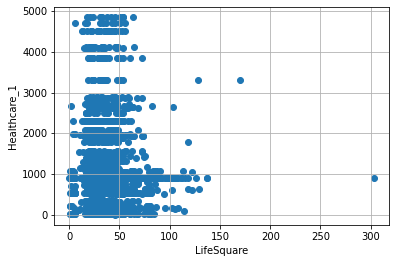

In [30]:
# Рассмотрим диграмму рассения по признакам LifeSquare и Healthcare_1 после замены пустых значений на медианные

plt.scatter(test['LifeSquare'], test['Healthcare_1'])
plt.xlabel('LifeSquare')
plt.ylabel('Healthcare_1')
plt.grid()
plt.show()  

In [31]:
# Как видно, имеются некоторые выбросы при LifeSquare > 150

test[test.LifeSquare > 150]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
410,11533,94,2.0,48.713443,303.071094,6.0,5,12.0,1974,0.521867,B,B,25,6149,0,900.0,0,0,B
2557,16053,17,4.0,168.729035,169.901701,0.0,4,0.0,2013,0.093443,B,B,23,4635,5,3300.0,2,4,B


In [32]:
# Удалим их

test = test.drop(test.index[[410,2557]], inplace=False)

In [33]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             4998 non-null   int64  
 1   DistrictId     4998 non-null   int64  
 2   Rooms          4998 non-null   float64
 3   Square         4998 non-null   float64
 4   LifeSquare     4998 non-null   float64
 5   KitchenSquare  4998 non-null   float64
 6   Floor          4998 non-null   int64  
 7   HouseFloor     4998 non-null   float64
 8   HouseYear      4998 non-null   int64  
 9   Ecology_1      4998 non-null   float64
 10  Ecology_2      4998 non-null   object 
 11  Ecology_3      4998 non-null   object 
 12  Social_1       4998 non-null   int64  
 13  Social_2       4998 non-null   int64  
 14  Social_3       4998 non-null   int64  
 15  Healthcare_1   4998 non-null   float64
 16  Helthcare_2    4998 non-null   int64  
 17  Shops_1        4998 non-null   int64  
 18  Shops_2 

In [34]:
test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000
mean,8410.442377,51.277511,1.909564,56.428583,35.405117,5.977991,8.633653,12.603641,1984.388956,0.119799,24.934174,5406.905962,8.264906,1028.967987,1.319528,4.243697
std,4832.230385,44.181512,0.838240,19.030112,15.344328,9.951650,5.483693,6.788226,18.571875,0.119958,17.535688,4027.392013,23.868206,766.073245,1.480087,4.777942
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,4221.250000,21.000000,1.000000,41.902306,25.849430,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.000000,1.000000
50%,8319.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000
75%,12596.750000,77.000000,2.000000,66.280855,41.757789,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.000000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,136.921090,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


Присутствуют следующие аномалии:

*  Объекты с нулевым количеством комнат;
*  Минальное зачение общей площади в 1,37 м^2;
*  25% объектов с площадью кухонь менее 1 м^2
*  Нулевая этажность зданий;

In [35]:
# Рассмотрим подробнее объекты с нулевым количеством комнат

test[test['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2406,3343,58,0.0,116.824201,113.692424,0.0,3,3.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
2524,10729,27,0.0,76.345154,42.820796,12.0,14,0.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B


In [36]:
# Подозрительный объект с общей площадью 116 м^2. При этом без комнат и кухни. Удалим его.

test = test.drop(labels=2406, axis=0, inplace=False)


In [37]:
# Просмотр распределения объектов по количеству комнат.

test['Rooms'].value_counts()

2.0     2029
1.0     1769
3.0     1099
4.0       89
5.0        7
6.0        2
0.0        1
17.0       1
Name: Rooms, dtype: int64

In [38]:
# Заменим единичный выброс в 17 комнат на моду (2 комнаты).

test.loc[test['Rooms'].isin([17]),'Rooms']=test['Rooms'].mode()

In [39]:
# Зададим минимальную площадь кухни не менее 3 м^2

test.loc[test['KitchenSquare'] <3, 'KitchenSquare'] = 3

In [40]:
# Заменим нулевую этажность домов на медианную

test.loc[test['HouseFloor'] == 0, 'HouseFloor'] = test['HouseFloor'].median()

In [41]:
# Анализ категориальных признаков

test.select_dtypes(include = 'object')

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,A
...,...,...,...
4995,B,B,B
4996,B,B,B
4997,B,B,B
4998,B,B,A


In [42]:
# Рассмотрим их подробнее

print(f" Для признака Ecology_2:\n {test['Ecology_2'].value_counts()}")
print()
print(f" Для признака Ecology_3:\n {test['Ecology_3'].value_counts()}")
print()
print(f" Для признака Shops_2:\n {test['Shops_2'].value_counts()}")

 Для признака Ecology_2:
 B    4949
A      48
Name: Ecology_2, dtype: int64

 Для признака Ecology_3:
 B    4848
A     149
Name: Ecology_3, dtype: int64

 Для признака Shops_2:
 B    4585
A     412
Name: Shops_2, dtype: int64


In [43]:
# Как и в обучающем датасете, здесь в каждом категориальном признаке по два значения. Заменим эти значения на бинарные.

test['Ecology_2'] = test['Ecology_2'].replace({'A':0, 'B':1})
test['Ecology_3'] = test['Ecology_3'].replace({'A':0, 'B':1})
test['Shops_2'] = test['Shops_2'].replace({'A':0, 'B':1})

In [44]:
# Еще раз рассмотрим обучающий датасет

test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4997 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             4997 non-null   int64  
 1   DistrictId     4997 non-null   int64  
 2   Rooms          4996 non-null   float64
 3   Square         4997 non-null   float64
 4   LifeSquare     4997 non-null   float64
 5   KitchenSquare  4997 non-null   float64
 6   Floor          4997 non-null   int64  
 7   HouseFloor     4997 non-null   float64
 8   HouseYear      4997 non-null   int64  
 9   Ecology_1      4997 non-null   float64
 10  Ecology_2      4997 non-null   int64  
 11  Ecology_3      4997 non-null   int64  
 12  Social_1       4997 non-null   int64  
 13  Social_2       4997 non-null   int64  
 14  Social_3       4997 non-null   int64  
 15  Healthcare_1   4997 non-null   float64
 16  Helthcare_2    4997 non-null   int64  
 17  Shops_1        4997 non-null   int64  
 18  Shops_2 

In [45]:
# Видно пустое значения в признаке Rooms

train[train['Rooms'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [46]:
# Переопределим датафрейм test, исключив из него строку с Rooms = NaN

test = test[test['Rooms'].notna()]

Тестовый датасет готов. Из исходного тестового датасета (5 000 строк) были исключены всего 4 строки.

# **Построение моделей**

Разбиение обучающего датасета на признаки и таргет

In [47]:
feature_names = ['DistrictId','Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',  'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1','Shops_2']
target_name = 'Price'

In [48]:
X = train[feature_names]
y = train[target_name]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [66]:
# Функция, которую будем использовать для оценки предсказания

def evaluate_preds(true_values, pred_values):
    print("Коэффициент детерминации R2:\t" + str(round(r2(true_values, pred_values), 3)))
    print("Средняя абсолютная ошибка MAE:\t" + str(round(mae(true_values, pred_values), 3)))
    print("Среднеквадратичная ошибка MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Прогнозируемые значения')
    plt.ylabel('Иcходные значения')
    plt.title('Исходные и прогнозируемые значения')
    plt.show()

Далее применим алгоритмы линейной регресии, случайного леса и сравним результаты.

## **LinearRegression**

In [67]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [68]:
y_train_preds = lr.predict(X_train)

Коэффициент детерминации R2:	0.53
Средняя абсолютная ошибка MAE:	44089.198
Среднеквадратичная ошибка MSE:	4048648926.948


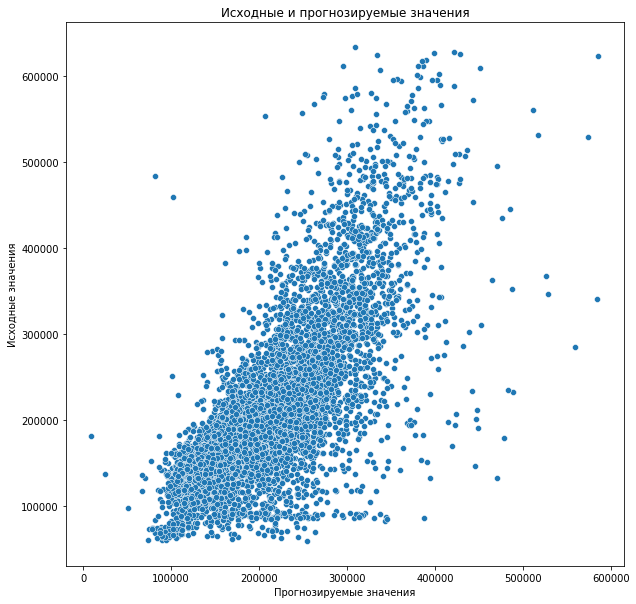

In [69]:
# Метрики для обучающей подвыборки

evaluate_preds(y_train, y_train_preds)

R2 = 0.53 - посредственный результат на обучающей подвыборке. 44089 USD на один объект недавижимости - cущественная средняя абсолютная ошибка. Разброс точек на графике также существенный. 

In [70]:
lr.fit(X_test, y_test)

LinearRegression()

In [71]:
y_test_preds = lr.predict(X_test)

Коэффициент детерминации R2:	0.491
Средняя абсолютная ошибка MAE:	45950.746
Среднеквадратичная ошибка MSE:	4396037160.011


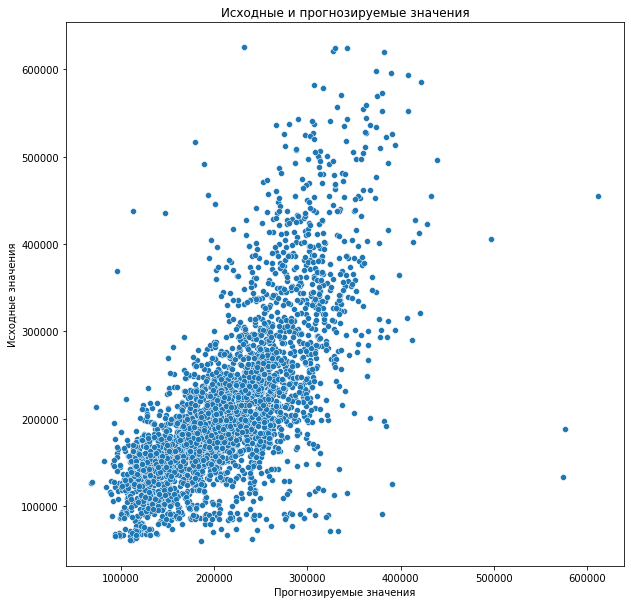

In [72]:
# Метрики для валидационной подвыборки

evaluate_preds(y_test, y_test_preds)

Схожий результат получился на валидационной подвыборке.

## **RandomForestRegressor**

In [73]:
rf_model = RandomForestRegressor(random_state=21) # наилучшие метрики получаются при random_state=21, а остальные параметры модели - по умолчанию
rf_model.fit(X_train,y_train)

RandomForestRegressor(random_state=21)

In [74]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

Коэффициент детерминации R2:	0.953
Средняя абсолютная ошибка MAE:	10769.675
Среднеквадратичная ошибка MSE:	338606936.117


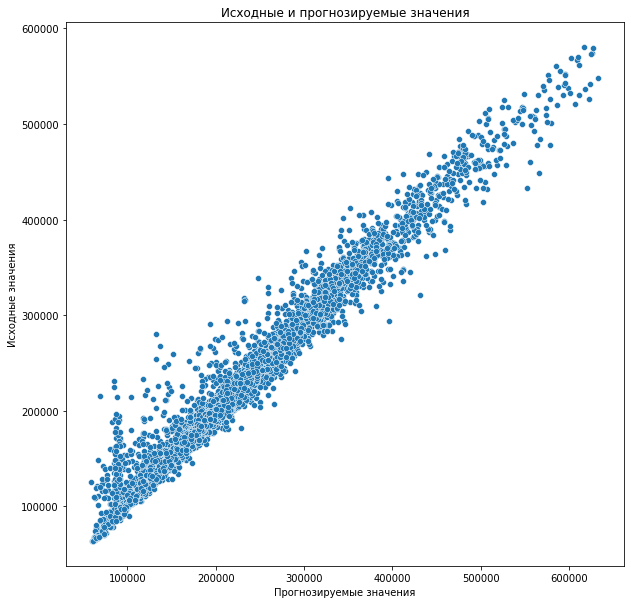

In [75]:
# Метрики для обучающей подвыборки

evaluate_preds(y_train_preds, y_train)

R2 = 0.953 - хороший результат на обучающей подвыборке. Средняя абсолютная ошибка на один объект недавижимости составила 10769 USD. Разброс точек на графике несущественный.

Коэффициент детерминации R2:	0.631
Средняя абсолютная ошибка MAE:	27970.672
Среднеквадратичная ошибка MSE:	2213207559.926


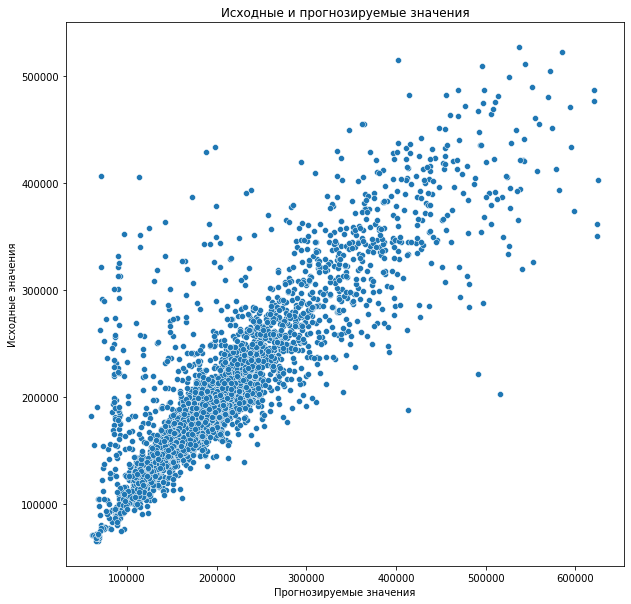

In [76]:
# Оценка для валидационной подвыборки

evaluate_preds(y_test_preds, y_test)

R2 = 0.631 - результат на  валидационной подвыборке несколько ниже, но соответствует заданию проекта. Средняя абсолютная ошибка на один объект недавижимости составила 27970 USD. Разброс точек на графике больше, чем на обучающей подвыборке.

In [77]:
# Кросс-валидация примененной модели (при разбиении на три блока) по метрике r2

cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv = KFold(n_splits = 3, shuffle = True, random_state=21))
cv_score

array([0.74377293, 0.71146068, 0.71740998])

Как видно, значение метрики на всех трех блоках  получилось приблизительно одинаковым. Хороший результат.

In [78]:
# Оценка важности признаков (после отработки модели)

feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), columns=['feature_name', 'importance'])

feature_importances.sort_values(by = 'importance', ascending = False)


,feature_name,importance
2,Square,0.398871
12,Social_2,0.106994
11,Social_1,0.084824
1,Rooms,0.068835
13,Social_3,0.049300
0,DistrictId,0.041301
8,Ecology_1,0.039206
7,HouseYear,0.038615
3,LifeSquare,0.034269
5,Floor,0.029663


Наиболее важным признаком (~40%) оказалась площадь объекта.

**Резюме. RandomForestRegressor показал результаты лучше в сравнении с LinerRegression. Применим первый алгоритм для предсказания по тестовому сету.**

In [79]:
# Предсказание для тестового сета

X2 = test.drop(['Id'], axis=1)
X2['Price'] = rf_model.predict(X2) #
X2['Price'].head()

0    160909.847059
1    216231.983819
2    205670.287624
3    334322.657733
4    144872.417739
Name: Price, dtype: float64

In [80]:
# Экспорт результата в сsv

pd.DataFrame({'Id':test['Id'], 'Price':X2['Price'] }).to_csv('/content/sample_data/AIvanov_predictions.csv', sep = ',', index=False) 